In [1]:
# necessary packages #

#using Pkg
#Pkg.add("Distances")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2
#using NearestNeighbors # Can't use KDtree in julia for posterior prediction

In [2]:
include("../../util.j")

colnorm (generic function with 1 method)

In [3]:
# unnecessary packages #

#using Pkg
#Pkg.add("UnicodePlots")
using UnicodePlots   # check the structure of the sparse matrix
using BenchmarkTools

using StatsPlots
using MCMCChains
using PrettyTables

In [4]:
#using Pkg
#Pkg.add("NearestNeighborDescent");
#using NearestNeighborDescent

In [5]:
@load "../data/sim1data.jld";

In [ ]:
using RCall
coords_R = transpose(coords_ord[:, S])
coords_Pre_R = transpose(coords_ord[:, M])
@rput X_ord
@rput Y_ord
@rput coords_R
@rput coords_Pre_R
@rput S
@rput M
@rput q

R"""
library(spBayes)
set.seed(1)
x.1 <- X_ord[S, ]; x.2 <- X_ord[S, ]
y.1 <- Y_ord[S, 1]; y.2 <- Y_ord[S, 2]
n.samples <- 20000
A.starting <- diag(1, q)[lower.tri(diag(1,q), TRUE)]
starting <- list("phi"=rep(3/0.5,q), "A"=A.starting, "Psi"=rep(1,q))
tuning <- list("phi"=rep(1,q), "A"=rep(0.01,length(A.starting)), "Psi"=rep(0.01,q))
priors <- list("beta.Flat", "phi.Unif"=list(rep(3 / 0.75,q), rep(3 / 0.25, q)),
               "K.IW"=list(q + 1, diag(1, q)), "Psi.ig"=list(c(2,2), c(0.2,0.2)))
t <- proc.time()
m.1 <- spMvLM(list(y.1~x.1-1, y.2~x.2-1),
                    coords=coords_R, starting=starting, tuning=tuning, priors=priors,
                    n.samples=n.samples, cov.model="exponential", n.report=100)
burn.in <- 0.75*n.samples
m.1 <- spRecover(m.1, start = burn.in)
print(proc.time()-t)
print(round(summary(m.1$p.theta.recover.samples)$quantiles[,c(3,1,5)],2))
print(round(summary(m.1$p.beta.recover.samples)$quantiles[,c(3,1,5)],2))

theta_samples <- m.1$p.theta.recover.samples
beta_samples <- m.1$p.beta.recover.samples
cat(m.1$run.time)

t <- proc.time()
out <- spPredict(m.1, start = burn.in, thin = 2, pred.covars = cbind(X_ord[M, ], X_ord[M, ]),
                pred.coords = coords_Pre_R)
cat("\n", proc.time() - t)

mean_quants <- function(x){c(mean(x), quantile(x, prob=c(0.5, 0.025, 0.975)))}
yhat <- apply(out$p.y.predictive.samples, 1, mean_quants)
m1_w_hat <- summary(mcmc(t(m.1$p.w.recover.samples)))$quantiles[,c(3,1,5)]
w_samples <- m.1$p.w.recover.samples

# size for the mapping of w               
width <- 360*3
height <- 360*3
pointsize <- 16

png(paste("../../pics/MCMC_sim1_spBayes.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
plot(m.1$p.theta.samples)
dev.off()


"""
@rget theta_samples
@rget beta_samples
@rget yhat
@rget m1_w_hat
@rget w_samples

┌ Warning: Package RCall does not have AxisArrays in its dependencies:
│ - If you have RCall checked out for development and have
│   added AxisArrays as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with RCall
│ Loading AxisArrays into RCall from project dependency, future warnings for RCall are suppressed.
└ @ nothing nothing:840
┌ Warning: RCall.jl: Loading required package: coda
│ Loading required package: magic
│ Loading required package: abind
│ Loading required package: Formula
│ Loading required package: Matrix
└ @ RCall /home/lu/.julia/packages/RCall/ffM0W/src/io.jl:113


----------------------------------------
	General model description
----------------------------------------
Model fit with 1000 observations.

Number of covariates 4 (including intercept if specified).

Using the exponential spatial correlation model.

Number of MCMC samples 20000.

Priors and hyperpriors:
	beta flat.

	K IW hyperpriors df=3.00000, S=
	1.000	0.000	
	0.000	1.000	

	Diag(Psi) IG hyperpriors
		parameter	shape	scale
		Psi[1,1]	2.0	0.20
		Psi[2,2]	2.0	0.20

	phi Unif hyperpriors
		parameter	a	b
		phi[1]		4.00000	12.00000
		phi[2]		4.00000	12.00000

-------------------------------------------------
		Sampling
-------------------------------------------------
Sampled: 100 of 20000, 0.50%
Report interval Metrop. Acceptance rate: 37.00%
Overall Metrop. Acceptance rate: 37.00%
-------------------------------------------------
Sampled: 200 of 20000, 1.00%
Report interval Metrop. Acceptance rate: 10.00%
Overall Metrop. Acceptance rate: 23.50%
-------------------------------------

In [ ]:
@save "../results/LMC_spbayes.jld" theta_samples beta_samples yhat m1_w_hat w_samples

# MCMC Chain check

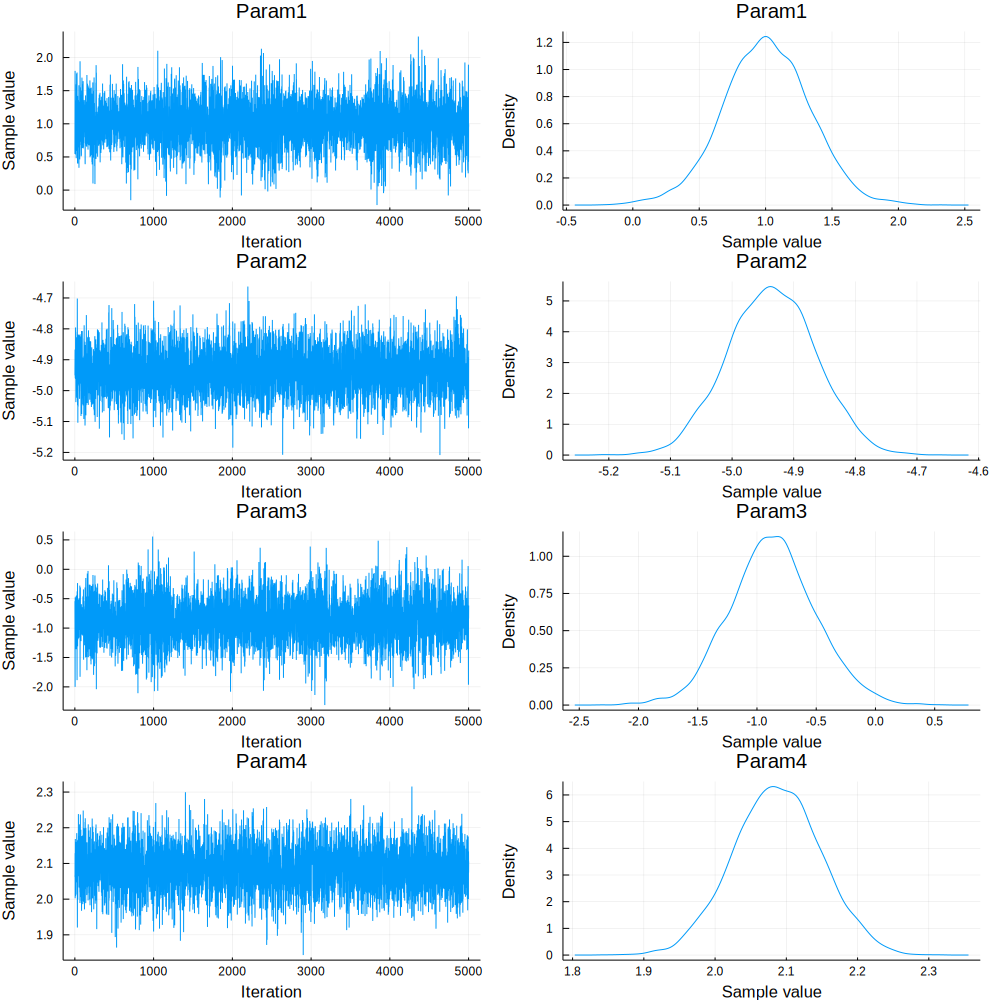

In [40]:
β_pos_sam = Array{Float64, 3}(undef, size(beta_samples)[1], p * q, 1);
β_pos_sam[:, :, 1] = hcat(beta_samples[:, 1], beta_samples[:, 2], beta_samples[:, 3], beta_samples[:, 4]);
β_chain = Chains(β_pos_sam);
pβ = plot(β_chain)

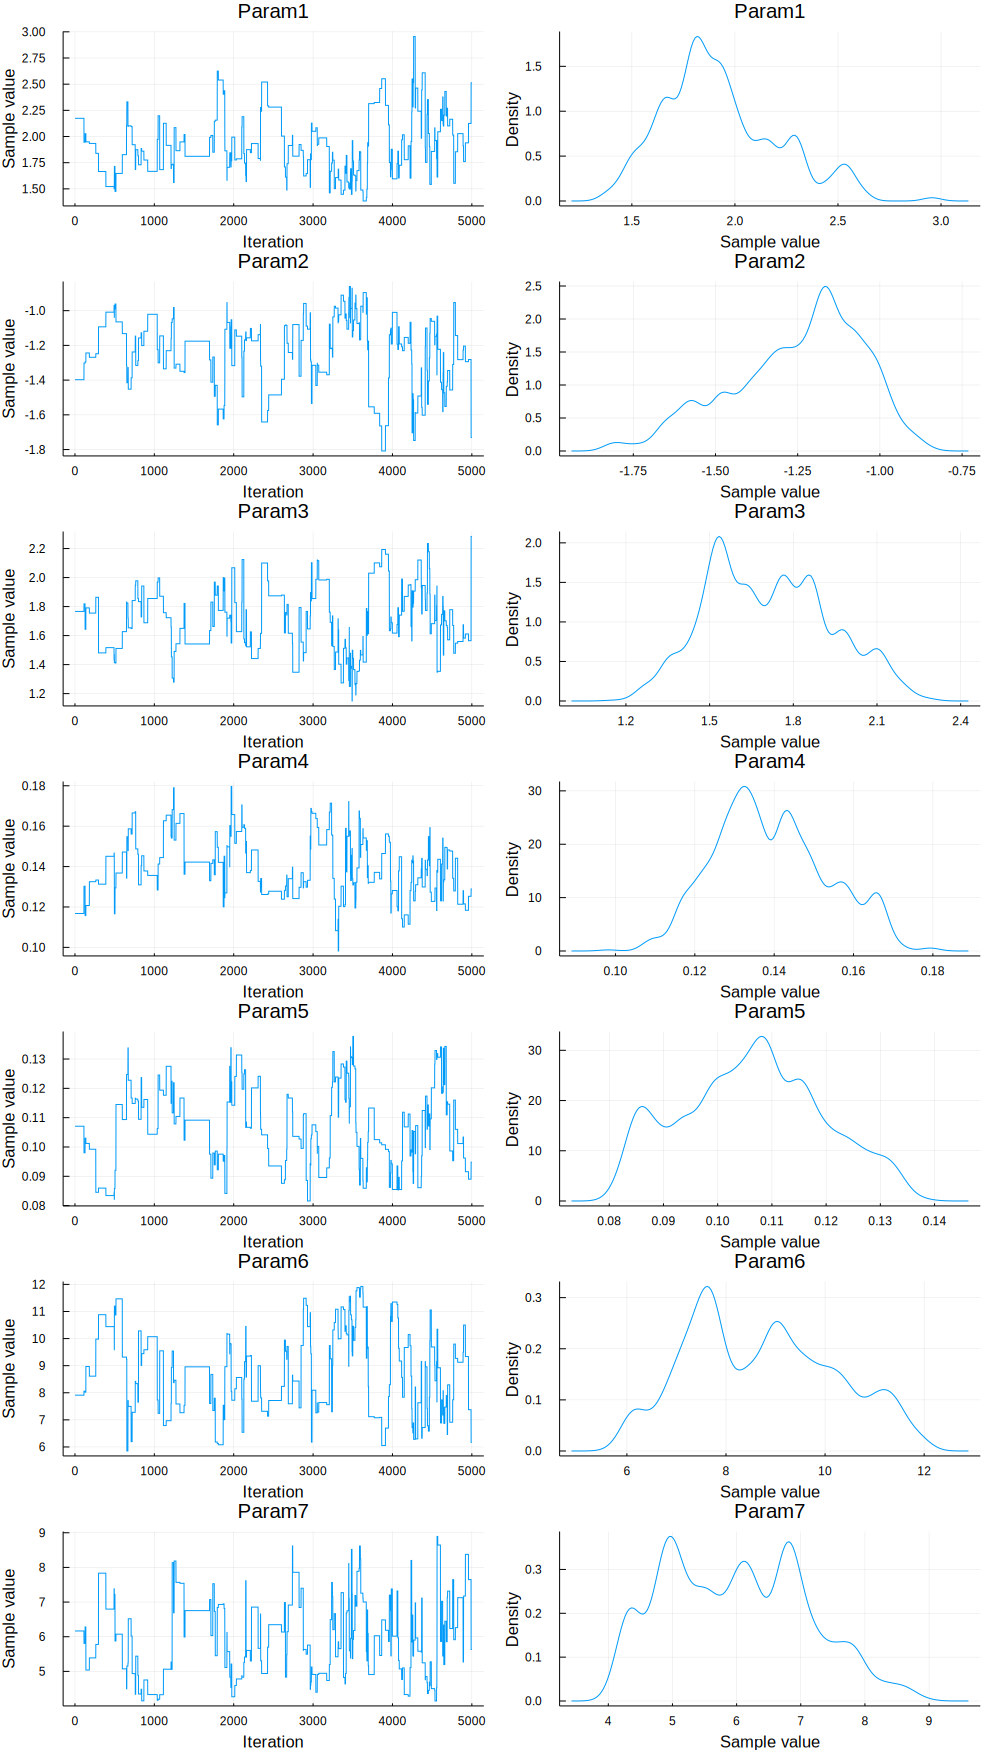

In [41]:
Λ_pos_sam = Array{Float64, 3}(undef, size(theta_samples)[1], size(theta_samples)[2], 1);
Λ_pos_sam[:, :, 1] = hcat(theta_samples[:, 1], theta_samples[:, 2], theta_samples[:, 3], theta_samples[:, 4],
    theta_samples[:, 5], theta_samples[:, 6], theta_samples[:, 7]);
Λ_chain = Chains(Λ_pos_sam);
pΛ = plot(Λ_chain)

# Posterior Inference

In [38]:
# count the covarage of 95% CI #???
nm = N - n;
count = fill(0.0, 2);
for j in 1:q
    for i in 1:nm
        count[j] = count[j] + 
        ((yhat[3, i + (j - 1) * nm] < Y_ord[M[i], j]) && 
            (yhat[4, i + (j - 1) * nm] > Y_ord[M[i], j]))
    end
end
count

2-element Array{Float64,1}:
 107.0
  79.0

In [39]:
count ./ nm

2-element Array{Float64,1}:
 0.535
 0.395

In [33]:
# calculate root mean square predictive error #
MSPE = mean((Y_ord[M, :] - [yhat[1, 1:nm] yhat[1, (nm + 1):(2 * nm)]]).^2)
#RMSPE = sqrt(MSPE); RMSPE

Inf

In [36]:
# count the covarage of 95% CI #
count_ω = fill(0.0, 2);
for j in 1:q
    for i in 1:n
        count_ω[j] = count_ω[j] + 
        ((m1_w_hat[i + (j - 1) * n, 2] < ω_ord[S[i], j]) && 
            (m1_w_hat[i + (j - 1) * n, 3] > ω_ord[S[i], j]))
    end
end
count_ω

2-element Array{Float64,1}:
 340.0
 334.0

In [37]:
count_ω ./ n

2-element Array{Float64,1}:
 0.34 
 0.334

In [28]:
Y_ord[M, :]

200×2 Array{Float64,2}:
 -0.0185268  -1.56851  
 -1.71492     1.15587  
 -4.32164     2.09095  
 -0.030581    0.895578 
 -4.06405     2.81296  
 -3.76679     0.801753 
 -4.53235     1.83386  
 -2.68757     0.0522415
 -1.71081    -1.0078   
 -2.13477    -0.54533  
 -1.39962    -0.751946 
  2.46556    -1.89934  
 -0.898392    0.894546 
  ⋮                    
 -1.87427     0.656473 
 -3.07011     1.60442  
 -3.90622     1.36228  
 -3.70719     0.726392 
 -2.69608     0.83968  
 -4.63062     2.81152  
 -5.45351     2.76692  
 -0.287535    0.102552 
 -1.02302     1.16845  
 -3.66102     0.385078 
 -4.12597     2.13181  
 -6.11943     2.62516  

In [24]:
yhat

4×400 Array{Float64,2}:
  0.510338  -1.02544   -2.6042   …   0.151633  -2.07825    1.45954 
  0.514414  -1.0329    -2.60147      0.153582  -2.07429    1.45332 
 -1.01873   -2.36697   -3.9809      -1.20702   -4.20118   -0.386335
  2.04016    0.333281  -1.18761      1.52026   -0.019083   3.35274 

In [21]:
N_Inf_burn = 1;
summary_table = Array{Float64, 2}(undef, Integer(p * q + q * (q + 1) / 2), 5);
summary_table[1, :] = vcat(β[1, 1], mean(beta_samples[:, 1]),
    quantile(beta_samples[:, 1], [0.5, 0.025, 0.975]));
summary_table[2, :] = vcat(β[1, 2], mean(beta_samples[:, 3]),
    quantile(beta_samples[:, 3], [0.5, 0.025, 0.975]));
summary_table[3, :] = vcat(β[2, 1], mean(beta_samples[:, 2]),
    quantile(beta_samples[:, 2], [0.5, 0.025, 0.975]));
summary_table[4, :] = vcat(β[2, 2], mean(beta_samples[:, 4]),
    quantile(beta_samples[:, 4], [0.5, 0.025, 0.975]));
summary_table[5, :] = vcat((1 / α - 1.0)* Σ[1, 1], mean(theta_samples[:, 4]),
    quantile(theta_samples[:, 4], [0.5, 0.025, 0.975]));
summary_table[6, :] = vcat((1 / α - 1.0) * Σ[2, 2], mean(theta_samples[:, 5]),
    quantile(theta_samples[:, 5], [0.5, 0.025, 0.975]));
summary_table[7, :] = vcat(ϕ1, mean(vcat(theta_samples[:, 6], theta_samples[:, 7])),
    quantile(vcat(theta_samples[:, 6], theta_samples[:, 7]), [0.5, 0.025, 0.975]));
summary_table = round.(summary_table; digits = 3);
rnames = ["β[1, 1]", "β[1, 2]", "β[2, 1]", "β[2, 2]", "(1/α - 1)Σ[1, 1]", "(1/α - 1)Σ[2, 2]", "ϕ1"];
summary_table = [rnames summary_table];
pretty_table(summary_table,  ["" "true" "mean" "median" "2.5%" "97.5%"], markdown)

|                  |  true |   mean | median |   2.5% |  97.5% |
|------------------|-------|--------|--------|--------|--------|
|          β[1, 1] |   1.0 |  1.006 |  1.005 |  0.336 |  1.648 |
|          β[1, 2] |  -1.0 | -0.868 |  -0.87 | -1.569 | -0.142 |
|          β[2, 1] |  -5.0 | -4.936 | -4.936 | -5.074 | -4.799 |
|          β[2, 2] |   2.0 |  2.087 |  2.087 |  1.967 |  2.207 |
| (1/α - 1)Σ[1, 1] | 0.222 |  0.139 |  0.137 |  0.116 |  0.167 |
| (1/α - 1)Σ[2, 2] | 0.167 |  0.106 |  0.107 |  0.083 |  0.131 |
|               ϕ1 |   6.0 |  7.363 |  7.172 |  4.332 |  11.35 |
